# Retrieve Streamflow data from the National Water Model for a Specified Location and Period


**Authors**: Irene Garousi-Nejad (igarousi@cuahsi.org), Anthony Castronova (acastronova@cuahsi.org) <br>
**Last updated**: Mar 28, 2024

This notebook shows how to access the National Water Model version 3 retrospective simulated data, in particular, the streamflow. Data is stored on AWS and can be accessed through the following link. This notebook has been tested on the CIROH 2i2c Cloud infrastructure. The printed computation times correspond to a **Medium server**, with 11GB of RAM and 4 CPUs. 

Funding Resources:

<img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CIROHLogo_200x200.png" width="100" height="20">     <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CUAHSI-4-color-logo_with_URL.png" width="300" height="300">

## 1. Import libraries, set up Dask, Define function and parameters

In [1]:
import os
import s3fs
import boto3
import fsspec
import pandas as pd
import numpy as np
import xarray as xr
import zarr
import glob
import rasterio
import pyproj
import geopandas
import matplotlib.pyplot as plt

In [2]:
import dask
from dask.distributed import Client
from dask.distributed import progress
try:
    print(client.dashboard_link)
except:    
    client = Client(n_workers=24, threads_per_worker=1, memory_limit='2GB') 
    print(client.dashboard_link)

/user/igarousi/proxy/8787/status


#### User defined parameters:

In [3]:
# NWM data link. This is the link to the LDASOUT outputs over the CONUS in the Zarr format
conus_bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr'

# USGD gage location
gage_id = '05245100'  
gage_lon=-94.8658552 
gage_lat=45.97496449

## 2. Load the NWM retrospective runs

Use Xarray to load the metadata, not the actual data, into the memory.

In [4]:
%%time

conus_bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr'

ds = xr.open_zarr(
        fsspec.get_mapper(
            conus_bucket_url,
            anon=True
        ),
        consolidated=True
)

ds

CPU times: user 13.9 s, sys: 2.94 s, total: 16.8 s
Wall time: 46.5 s


<xarray.Dataset>
Dimensions:         (feature_id: 2776734, time: 385704)
Coordinates:
    elevation       (feature_id) float32 dask.array<chunksize=(2776734,), meta=np.ndarray>
  * feature_id      (feature_id) int64 101 179 181 ... 1180001803 1180001804
    gage_id         (feature_id) |S15 dask.array<chunksize=(2776734,), meta=np.ndarray>
    latitude        (feature_id) float32 dask.array<chunksize=(2776734,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(2776734,), meta=np.ndarray>
    order           (feature_id) int32 dask.array<chunksize=(2776734,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1979-02-01T01:00:00 ... 2023-02-01
Data variables:
    crs             |S1 ...
    qBtmVertRunoff  (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBucket         (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    q_lateral       (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    streamflow      (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    velocity        (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
Attributes:
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    featureType:          timeSeries
    history:              Thu Sep 28 07:58:36 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [14]:
# not working!!
# ds.where((ds.gage_id==gage_id), drop=True)
# Could we add gage_id to the dimensions?

The dataset has two dimensions (**time** and **feature_id**) and seven coordinates (such as **elevation**, **gage_id**, **latitude**, etc.) Using `.sel()` from Xarray makes it easy to create a subset of data for a specified <span style="color:blue;">*dimension*</span>. However, when it comes to subsetting based on specific <span style="color:blue;">*coordinate*</span> values, `.sel()` is not applicable. For example, if we have the `feature_id`, we can easily do:

In [7]:
start_date = pd.to_datetime('2007-10-01')
end_date = pd.to_datetime('2007-10-30')
ds.sel(feature_id=1180001802).sel(time=slice(start_date, end_date))

<xarray.Dataset>
Dimensions:         (time: 697)
Coordinates:
    elevation       float32 dask.array<chunksize=(), meta=np.ndarray>
    feature_id      int64 1180001802
    gage_id         |S15 dask.array<chunksize=(), meta=np.ndarray>
    latitude        float32 dask.array<chunksize=(), meta=np.ndarray>
    longitude       float32 dask.array<chunksize=(), meta=np.ndarray>
    order           int32 dask.array<chunksize=(), meta=np.ndarray>
  * time            (time) datetime64[ns] 2007-10-01 ... 2007-10-30
Data variables:
    crs             |S1 ...
    qBtmVertRunoff  (time) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    qBucket         (time) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    qSfcLatRunoff   (time) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    q_lateral       (time) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    streamflow      (time) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    velocity        (time) float64 dask.array<chunksize=(73,), meta=np.ndarray>
Attributes:
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    featureType:          timeSeries
    history:              Thu Sep 28 07:58:36 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

## 3. Retrieve data for a specified dimension

The dataset has two dimensions (**time** and **feature_id**) and seven coordinates (such as **elevation**, **gage_id**, **latitude**, etc.) Using `.sel()` from Xarray makes it easy to create a subset of data for a specified <span style="color:blue;">*dimension*</span>. For example, if we have the `feature_id`, we can easily do:

In Dask, you can use the `.persist()` method to control when computations are performed and when results are stored in memory. If you want to remove the data from memory after you have computed it, you can use the `.persist()` method followed by the `.close()` method.

#### Feature_id

In [8]:
%%time
results = ds.sel(feature_id=1180001802).persist().compute()
results.close()  # close to free up memory

ERROR:tornado.application:Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7c8345467e50>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/bokeh/server/tornado.py", line 760, in _keep_alive
    c.send_ping()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/bokeh/server/connection.py", line 93, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/websocket.py", line 444, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-03-28 12:54:33,253 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7c8345467e50>>
Traceback (most recent ca

CPU times: user 32.7 s, sys: 9.25 s, total: 42 s
Wall time: 3min 54s


Another example is to use `sel()` to select all time steps on April 5th because `time` is a dimension. The following code returns all records for April 5, 2007.

#### time

In [9]:
%%time
results = ds.sel(time='2007-04-05').persist().compute()
results.close()

CPU times: user 13.5 s, sys: 6.82 s, total: 20.3 s
Wall time: 1min


> **Note:** Note that subsetting based on `feature_id` takes much longer compared to subsetting based on `time`. 

However, when it comes to subsetting based on specific <span style="color:blue;">*coordinate*</span> values (for example the latitude and longitude), `.sel()` is not applicable. For example, if we try the same process for a specific coordinate value, such as a known geo-location like a USGS gage with its latitude and longitude, using `.sel()` would result in <span style="background-color: lightpink; color: red; font-family: 'Courier New', monospace;">KeyError: </span><span style="background-color: lightpink; color: black; font-family: 'Courier New', monospace;">"no index found for coordinate 'latitude'"</span>

In [11]:
# Uncomment the following and run it to see the error
# target_lat = 45.12
# target_lon = -93.5
# ds.sel(latitude=target_lat, longitude=target_lon)

## 4. Retrieve data for a specified coordinate

One example can be creating a subset for a specific geo-location. Since the exact values of the gage's latitude and longitude may not be present in the dataset, we can use the following approache which calculates the **Euclidean distance** to find the closest point. 

In [8]:
# this step is time consuming and uses a lot of memory (still 
# need to double check if the memory usage is related to the search algorithm). Divide this cell into two to evaluate this assumption.
# We might be able to change this section by
# using a pre-calculated feature_id for associated gage_id. Similar to what 
# already exists on HydroShare, done by another researcher. We should cite them
# but may need to create a newer version for v3.

%%time 

# Calculate the Euclidean distance to find the closest point
distances = np.sqrt((ds.latitude - gage_lat)**2 + (ds.longitude - gage_lon)**2)

# Find the index of the minimum distance
min_distance_index = np.unravel_index(distances.argmin(), distances.shape)

# Extract the subset based on the indices
subset = ds.isel(feature_id=min_distance_index[0].item()).compute()


CPU times: user 37.3 s, sys: 11.7 s, total: 49 s
Wall time: 5min 24s


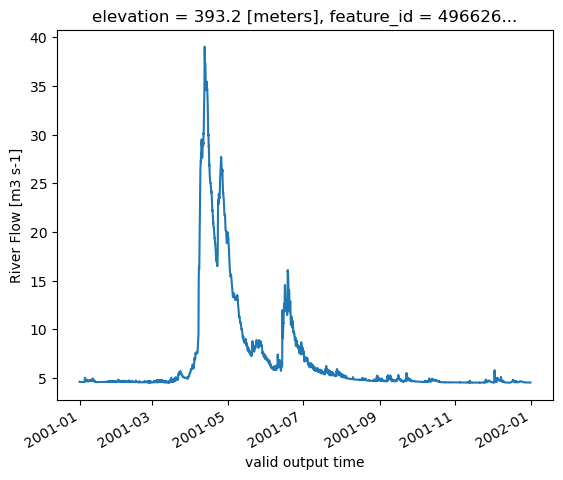

In [11]:
ds.sel(time='2001').sel(feature_id=4966267).streamflow.plot();

In [13]:
ds.sel(time='2001').sel(feature_id=4966267).gage_id.values

array(b'       05245100', dtype='|S15')

In [18]:
distances = np.sqrt((ds.latitude - gage_lat)**2 + (ds.longitude - gage_lon)**2)

min_distance_index = np.unravel_index(distances.argmin(), distances.shape)

subset = ds.isel(feature_id=min_distance_index[0].item())

In [19]:
subset.feature_id.values

array(4966287)

In [17]:
subset.gage_id.values

array(b'               ', dtype='|S15')

In [22]:
subset = ds.sel(feature_id=4966267)

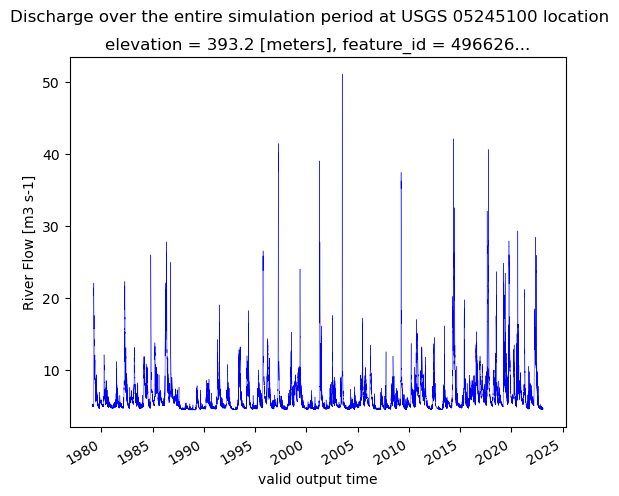

In [23]:
subset.streamflow.plot(color='b', linewidth=0.3, label='hourly')
plt.suptitle(f'Discharge over the entire simulation period at USGS {gage_id} location')
plt.show()

In the context of Dask and xarray, the `.plot()` method is typically not considered an action that triggers immediate computation. Instead, it is usually a lazy operation that creates a plotting task or object. When you call `.plot()`, it sets up the necessary information for the plot, but the actual rendering of the plot occurs when you explicitly call `plt.show()` or perform another action that triggers the visualization.

In [24]:
%%time
subset_df = subset.streamflow.to_dataframe()
subset_df.to_csv(f'subset_all_retrospective_streamflow_at_usgs_{gage_id}.csv')

CPU times: user 11 s, sys: 2.25 s, total: 13.3 s
Wall time: 46.9 s


In [25]:
year = 2001
subset_df_2001 = subset_df[subset_df.index.year == year]
subset_df_2001.to_csv(f'subset_{year}_retrospective_streamflow_at_usgs_{gage_id}.csv')

## 5. Perform some statistical analysis

#### TODO